In [1]:
#package needed
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def generate_mixture(n_sample,cluster_mean):
    
    """
    Sample from a mixture of univariate Gaussians with given mean, 
    and unit variance. An equal number of observations is sampled from 
    each of the k-th mixture. 
    
    Parameters
    -----------
    n_sample: int 
        number of samples for each mixture 
    cluster_mean: list
        mixture means
        
    Returns
    -------
    sample: np.array of dim (n,1)
    
    """
    
    sample = []
    
    for k in range(len(cluster_mean)):
        sample.extend(list(np.random.normal(cluster_mean[k], 1, n_sample)))
    
    sample = np.array(sample)[:,np.newaxis]
    return sample

class CaviGaussianMixture: 
    
    def __init__(self,
                 input_data,K,sigma_sq=2):
        
        """
        Parameters
        ----------
        input_data: np.array of dim (n,1)
        K: int
            known number of clusters
        sigma_sq: int
            hyperparameter prior variance of 
            mean
        """
        
        self.x = input_data  
        self.n = len(input_data)
        self.K = K 
        self.sigma_sq = sigma_sq 
        
        #initialization of variational parameters
        self.varphi = np.random.random(size=(self.n,self.K)) #shape: (n,K)
        self.m = np.random.randint(min(self.x),max(self.x),K) #shape: (K,1)
        self.s_sq = np.random.random(K) #shape: (K,1)
        
        self.ELBO = None 
        self.ELBO_list = []
        
    def updates_variational_parameters(self):
        
        #update varphi
        update_varphi = np.exp(np.outer(self.x, self.m) -(self.m**2 + self.s_sq)/2)
        #normalize varphi to be in [0,1]
        self.varphi = update_varphi/np.sum(update_varphi, axis=1)[:,np.newaxis]

        #update m
        self.m = np.sum(self.varphi * self.x,axis=0) / (1/self.sigma_sq + np.sum(self.varphi,axis=0)) 

        #update s_sq
        self.s_sq = 1 / ((1/self.sigma_sq) + np.sum(self.varphi,axis=0)) 
        
    def track_ELBO(self):
        
        #ELBO computation
        self.ELBO = -np.sum((self.s_sq + self.m**2), axis=0)/(2*self.sigma_sq) + \
        np.sum((self.varphi)*(np.outer(self.x, self.m) - np.add.outer(self.x**2,self.m**2 + self.s_sq)/2)) + \
        - np.sum(np.log(self.varphi)) + np.sum(np.log(self.s_sq)/2)
                
        return self.ELBO
    
    def CAVI(self, n_iters = 1000):
        """
        Update to the variational paramaters,
        and computation of the ELBO. When it does not
        vary much from the previous iteration (1e-3),
        the algorithm has converged.
        
        Parameters
        -----------
        n_iters: int 
           maximum number of iteration to perform 
        
        """
        
        #ELBO in the initialization
        ELBO = self.track_ELBO()
        self.ELBO_list.append(ELBO)
        
        for i in range(n_iters):

            self.updates_variational_parameters()

            ELBO = self.track_ELBO()
            self.ELBO_list.append(ELBO)
                        
            if np.abs(self.ELBO_list[-1] - self.ELBO_list[-2])<= 1e-3:
                print(f"convergence at iteration: {i}, ELBO reached: {ELBO}")
                print(f"approx of cluster means: {np.sort(self.m)} ")
                break
        return ELBO
        

In [7]:
data = generate_mixture(500,[2,4,8,13,17])
caviclass = CaviGaussianMixture(data,5)
caviclass.CAVI()
m = caviclass.m

convergence at iteration: 28, ELBO reached: -2765576.42019202
approx of cluster means: [ 1.9918963   3.92879675  7.99157129 13.00352925 16.97298358] 


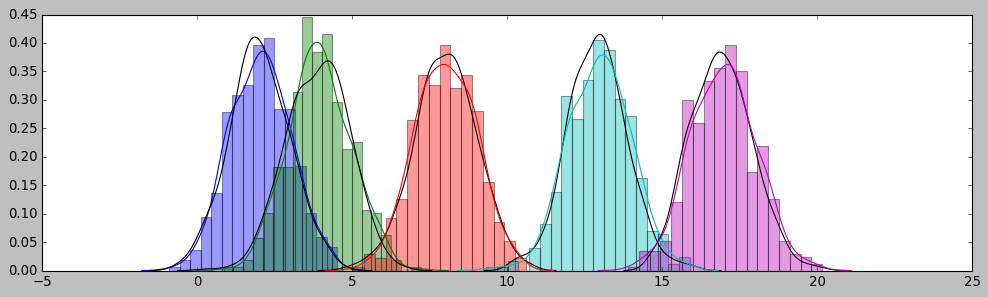

In [49]:
#Approximation plot
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 4))
sns.distplot(data[:500], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(m[0], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(data[500:1000], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(m[1], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(data[1000:1500], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(m[2], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(data[1500:2000], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(m[3], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(data[2000:2500], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(m[4], 1, SAMPLE), color='k', hist=False, kde=True)
fig.savefig("normal.png")

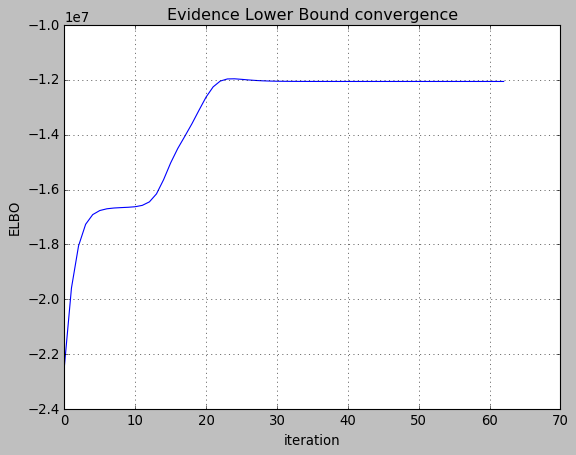

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('classic')
fig, ax = plt.subplots()
ax.plot(caviclass.ELBO_list[3:])

ax.set(xlabel='iteration', ylabel='ELBO',
       title='Evidence Lower Bound convergence')
ax.grid()

fig.savefig("elbo1.png")
plt.show()

In [12]:
list_init = []
init = 5 

for i in range(init):
    caviclass = CaviGaussianMixture(data,5)
    caviclass.CAVI()

    list_init.append(caviclass.ELBO_list)
    


convergence at iteration: 75, ELBO reached: -3683374.3652371257
approx of cluster means: [ 2.8545605   7.74741485 12.44860391 13.64780639 17.07634501] 
convergence at iteration: 92, ELBO reached: -2782107.421650981
approx of cluster means: [ 2.05308259  3.91580256  8.00340531 12.98552907 16.97212968] 
convergence at iteration: 93, ELBO reached: -2782107.4214179986
approx of cluster means: [ 2.05308259  3.91580256  8.00340531 12.98552907 16.97212968] 
convergence at iteration: 50, ELBO reached: -2782107.421585289
approx of cluster means: [ 2.05308259  3.91580256  8.00340531 12.98552907 16.97212968] 
convergence at iteration: 57, ELBO reached: -2782107.419707017
approx of cluster means: [ 2.05308259  3.91580256  8.00340531 12.98552907 16.97212968] 


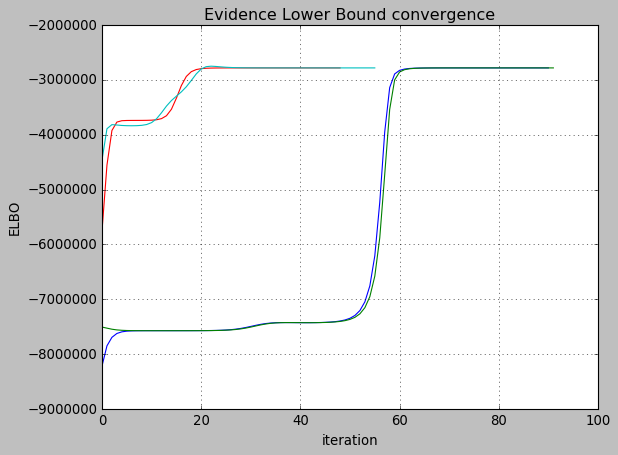

In [33]:
fig, ax = plt.subplots()
plt.style.use('classic')
for i in range(len(list_init)):
    if i!=0:
        plt.plot(list_init[i][3:])
        #ax.plot(caviclass.ELBO_list[:3])

ax.set(xlabel='iteration', ylabel='ELBO',
           title='Evidence Lower Bound convergence')
ax.grid()
fig.savefig("elbo2.png")
